![alt text](https://camo.githubusercontent.com/213999fa2ac3c88e78097000fe4f6d254bb77b04/687474703a2f2f69766d2e76752e6e6c2f656e2f496d616765732f49564d5f6c6f676f5f726762325f74636d3233342d3835313539342e737667)

<div style="text-align: right">  
Notebook by Sem Vijverberg & Ted Veldkamp <br>
</div>

# Drought risk part 1: ENSO impact on drought hazard for Kenya



## Introduction

In the lecture, you were taught about ways to estimate meteorological, agricultural, and hydrological drought hazard. Either by using standardized indicators (SPI, SPEI, SSFI) or by fixed or variable threshold level methods (Q90). In this practical, you will quantify African drought using the SPI indicator and discover the impact of ENSO on Drought. 

Learning goals for this practicum are:
- Learn to apply standardized methods to represent meteorological and hydrological drought hazard;
- Learn to deal with multi-dimensional climate datasets.
- Learn to visualize and interpret the results from drought hazard calculation methods.

## Performing the exercise
To run any code in the code-boxes below use *shift+enter*. **Action** denotes where you have to make changes to particular pieces of code. You can run the entire of code by pressing ctrl+F9 (windows) or CMD+F9 (Mac). 

## Documenting your results
See the **Answer_sheet.docx** in the main repository. Make sure you safe the requested outputs (figures, tables) and answers to questions here. You can store the progress of the Notebook by simpling pressing CMD+s or CTRL+s. Only the Answer_sheet.docx should be handed in per team.

## Working on a Google colab notebook?
Google colab allows users to run a Jupyter notebook environment entirely in the cloud. You get your own computing environment, which can run Python3 code. Python depends heavily on open-source packages. Since the computing environment is initially empty, you will need to install the required packaged first (via de !pip install command, see the cell below). You only need to do this once!   

## Installing Python packages (only for Google Colab)

In [ ]:
!pip install numpy
!pip install scipy
!pip install matplotlib==2.2.3
# !apt-get install -qq libgdal-dev libproj-dev
# !pip install cartopy==0.17.0
# !apt-get -qq install python-cartopy python3-cartopy
# Installing Cartopy work around:
!grep '^deb ' /etc/apt/sources.list | \
  sed 's/^deb /deb-src /g' | \
  tee /etc/apt/sources.list.d/deb-src.list
!apt-get -qq update

!apt-get -qq build-dep python3-cartopy
!pip uninstall -y shapely

!pip install --no-binary cartopy cartopy==0.17.0

!pip install pandas==1.0.3
!pip install xarray
!pip install netCDF4

## 1: Importing Python packages

Before running any Python script (in an offline or online modus) it is necessary to import a number of Python packages that can help you with performing the calculations. 

**Action**: Perform the script in the code-boxes below by selecting them and press *crt+enter* (this will not be mentioned anymore afterwards).

In [ ]:
# Import working modules
import xarray as xr
import numpy as np
import scipy.stats as stats
import matplotlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import inspect, os, sys
# Suppress future warning of Python packages which only confuse you guys... I will (try to) keep it working
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from google.colab import output
output.clear()


In [ ]:
# Mount Google Drive and define paths
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# Define paths

workingfolder = "/content/gdrive/My Drive/CIP_drought_impact/"
# uncomment this line below if you use a local jupyter notebook. 
# workingfolder = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
Notebooks_path = os.path.join(workingfolder, 'Notebooks/')

# adding path of notebooks to sys.path
if Notebooks_path not in sys.path:
    sys.path.append(Notebooks_path)
# importing own .py files from Notebook_path
import core_pp
import func_SPI

matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['legend.fontsize'] = 'large'

In the Data-folder a number of files have been prepared that serve as input for this exercise. First, open the "precip_file" and "evap_file" familiarize yourself with the data. 

**Action**: Make sure that path is correct. If needed, make changes to input_folder and input_file. Afterwards run the code by pressing *ctrl+enter*.

In [ ]:
inputfolder   = os.path.join(workingfolder, 'Data')

# Name input file
precip_file   = os.path.join(inputfolder,'p_1979-2018_Africa.nc')
country_codes = os.path.join(inputfolder,'Africa_mask_Countries.nc')
sst_Pacific   = os.path.join(inputfolder,'sst_1979-2018_ENSO_region.nc')

## 2: Loading and inspecting Precipitation data

You will now start with loading and inspecting the input data within Python Jupyter Notebooks. You will do this in the following code-box. Press *ctrl+enter* to run the code.

Load the data into the memory of this kernel.

In [ ]:
precip_m  = core_pp.import_ds_lazy(precip_file, format_lon='west_east')

### 2a: Inspecting the data
In python you can store data in different manners. Famous data types are Lists, Numpy arrays, dictionairies, or pandas Dataframe. Each data type has advantages and disadvantage. An xarray.DataArray is super handy for multi-dimensional datasets. It is like an excell sheets, but we can add as many dimensions as we want. For normal Excell sheets, we are limited to either the row or column dimensions, xarray can handle multiple. In this case, we see the time, latitude (imagine the y-axis) and longitude (imagine the x-axis) dimensions. We can also see that units are in Meters (per day), lets convert that to mm per day get a better feeling.

Let's have a look a the xr.DataArray() format:

In [ ]:
precip_m

In [ ]:
precip = precip_m * 1000
precip.name = 'Precipitation [mm/day]'
precip.attrs['units'] = '[mm/day]'

In the cell below we create the most simple plot of the climatological rainfall over Africa. For a climatology, we at least need 30 years. This is true particularly for precipiation, some argue we need at least 50 years to get a good climatology.


In [ ]:
(precip).mean(dim='time').plot.contourf()

**Question 1:** Plotting the climatological mean value is often one of the first things to do when analyzing a dataset. Why do you think we need more years to get a robust climatology compared to other variables? Tip: perhaps revisit this question after you finished section 3 once you've had a closer look at the distribution.

Using the Python Package Cartopy (ccrs), we can make nice spatial maps.

In [ ]:
# Figure 1
# Use Cartopy Python package to plot a map and draw country lines
map_proj = ccrs.PlateCarree(central_longitude=10)

fig = plt.figure(figsize=(30,10) )

# plot precipitation
# The integer numbers for plt.subplot refer to (n_rows, n_cols, 'index of figure') 
ax1 = plt.subplot(1, 1, 1, projection=map_proj) 
colormap = plt.cm.Blues
precip.mean(dim='time').plot.contourf(ax=ax1, transform=ccrs.PlateCarree(), 
                             subplot_kws={'projection': map_proj},
                             cmap=colormap)
ax1.coastlines()

**Question 2:** Briefly explain what you can learn/observe in figure 1. (insert figure)

### 2b: Retrieve data for Kenya
First we will focus on quantifying drought in Kenya. In order to retrieve only data from that country, we load the 'country_codes'.

Load country_codes and select precipiation and evaporation of Kenya:

In [ ]:
country = xr.open_dataset(country_codes).country_mask
land_sea_mask = country >= 1
map_proj = ccrs.PlateCarree(central_longitude=10)
colormap = plt.cm.gist_ncar_r
fig = plt.figure(figsize=(15,10) )

ax1 = plt.subplot(1, 1, 1, projection=map_proj)
country.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                            subplot_kws={'projection': map_proj},
                            cmap=colormap,
                            vmin=0, vmax=country.max())

The *country* file contains an attribute called 'country_code'. The following cell will convert this information into a Python dictionairy. A python dictionairy consists of keys and items in the following format: {*key1* : *item1*}. In the following, the key refers to an abbreviation of the country nams and the item refers to the numbers in the country mask. 

We will focus the coming analysis on Kenia, which has the *key* KE. 

In [ ]:
c_list = country.attrs['country_code']
codes_dict = {}
for i in np.arange(0,len(c_list),2):
    codes_dict[str(c_list[i])] = int(c_list[i+1])
codes_dict['KE']

Thus we need to gridpoints corresponding to number 115 in the *country* xarray. We will make a boolean mask (consisting of only True and False), which will only be True at Kenya. We can use that mask to select the gridcells of the *precip* and *evap* xarray.

In [ ]:
Kenya_mask = country.values == 115
Kenya_mask = (('latitude', 'longitude'), Kenya_mask )
precip.coords['mask'] = Kenya_mask
pr_kenya = precip.where(precip.mask)


In [ ]:
map_proj = ccrs.PlateCarree(central_longitude=10)

fig = plt.figure(figsize=(30,10) )

# plot precipitation
ax1 = plt.subplot(1, 2, 1, projection=map_proj)
colormap = plt.cm.Blues
pr_kenya.mean(dim='time').plot(ax=ax1, transform=ccrs.PlateCarree(), 
                             subplot_kws={'projection': map_proj},
                             cmap=colormap,
                             vmin=-3, vmax=3)
ax1.coastlines()
# # plot evaporation
# ax2 = plt.subplot(1, 2, 2, projection=map_proj)
# colormap = plt.cm.RdBu
# ev_kenya.mean(dim='time').plot(ax=ax2, transform=ccrs.PlateCarree(), 
#                              subplot_kws={'projection': map_proj},
#                              cmap=colormap,
#                                 vmin=-3, vmax=3)
# ax2.coastlines()

## 3: SPI for a single gridcell in Kenya

### Steps to calculate SPI

1. SPI is bases on temporally aggregated values of precipitation (in mm). Common temporal aggregations are 1, 3 and 6 months, but their is no strict convention. You can simply call it SPI-x, with x representing the amount of accumulated months.
2. We then fit a distribution (across years), often using the gamma distribution. However, given the strong heterogeneity around the globe, this distribution is not always the best. Preferably one tests different distributions, and chooses the best one. For this exercise, we will stick to the Gamma distribution for simplicitiy.  
3. The fitted distribution gives us the probability that a value occurs, this probability is transformed to standard normal distribution to ease interpretation. Stagge et al. (2015) pointed out that we should remove all zeros when we do this transformation to ensure that the mean of the new standard normal distribution will be zero.   

Note, since we are working with daily data, we take aggregation over i-days, representing the monthly aggregations. i.e. 1, 3, 6, which are considered equivalent to 31, 91, 183 days.


### First get a single gridcell from Kenya

In [ ]:
# we need to do a technical conversion to retrieve only the gridcells of Kenya
np_pr_kenya = np.reshape(pr_kenya.values, (pr_kenya.time.size, -1))
mask_NanIsFalse   = ~np.isnan(np_pr_kenya) # where are values not NaN 
# select only where values not NaN (Kenya gridcells)
pr_kenya_v  = np_pr_kenya[mask_NanIsFalse].reshape( pr_kenya.time.size, -1) 
df_kenya = pd.DataFrame(pr_kenya_v, index=pr_kenya.time.values) # make a pandas dataframe

# single gridcell
i_gridcell = 0
df_gs = df_kenya[i_gridcell]

#### step 1: Apply rolling sum

In [ ]:
SPI_aggr = 6
months = [1, 3, 6]
days = [31, 91, 183]
SPI_to_days = {months[i]:days[i] for i in range(len(months))}
SPI_window = SPI_to_days[SPI_aggr]

# the following line calculates a sum of window size {SPI_aggr}, using equal weights. 
df_kenya = df_gs.rolling(window=SPI_window, min_periods=1, center=True, axis=0).sum()

#### step 2: Fit distribution for single gridcell and single day of year

In [ ]:
# Because we are calculating SPI-{n} for each day of the year by using the rolling sum approach,
# we only need to select a single day to represent a n-month aggregation. 

# to select the SPI for month m (with 1 = jan and 12 = Dec):
m = 4
dates = df_gs.index
doy = int(np.mean(dates.dayofyear[dates.month == m])) # central dayofyear for the given month {m}

df_gs_m = df_gs[dates.dayofyear == doy]

# Fit Gamma distibution
# note floc avoids loc being fitted, see Stagge et al. 2015
a, loc, scale = stats.gamma.fit(df_gs_m.values, loc=0) # fit parameters of gamma distribution to SPI data 
params = [a, loc, scale]
rv = stats.gamma(*params) # Continuous random variable class, can sample randomly from the gamma distribution we just fitted  


fig = plt.figure(figsize=(30,10) )
l1=plt.plot(df_gs_m, '.k', markersize=20, color='b')
plt.ylabel('',size=15)
plt.title('',size=25)
plt.show()

#### Intermediate step: Using Kolmogorov-Smirnov test to test goodness-of-fit:

In [ ]:
params = [a, loc, scale]
D, p = stats.kstest(df_gs_m, 'gamma', args=params)  
print('pvalue: ', p)

**Question 3**: Discuss whether the presented pvalue is sufficient. What hypothesis does the K-S test actually test? Have a look at the Scipy description: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html

In [ ]:
# df_gs_m is precipitation of single gridcel for a single month, with a single value for each year
fig = plt.figure(figsize=(30,10) )

# plot observed values
ax1 = plt.subplot(1, 2, 1)
vals = ax1.hist(df_gs_m, density=True, bins=20, label='Dist. Data')
# plot fitted distribution
x = np.linspace(stats.gamma.ppf(0.01, a, loc=loc, scale=scale),
                stats.gamma.ppf(0.99, a, loc=loc, scale=scale), 100)
ax1.plot(x[1:], rv.pdf(x)[1:], 'k-', lw=2, label='Gamma dist. fitted')
ax1.legend(loc='best')
ax1.set_title(f"K-S test pvalue: {round(p, 2)}", fontsize=25)


ax2 = plt.subplot(1, 2, 2)
ax2.plot(df_gs_m,'.k');
ax2.set_title('Raw data')

#### step 3: Transform to standard normal distribution

In [ ]:
# 3c. Transform to standard normal distribution (and account for zero values (cfr. Stagge et al. 2015))  
indices_nonzero = np.nonzero(df_gs_m.values)[0]
nyears_zero = len(df_gs_m) - np.count_nonzero(df_gs_m)
ratio_zeros = nyears_zero / len(df_gs_m)

p_zero_mean = (nyears_zero + 1) / (2 * (len(df_gs_m) + 1))           

prob_gamma = (df_gs_m * 0 ) + p_zero_mean
# probability of values, given the Gamma distribution
prob_gamma[indices_nonzero] = ratio_zeros+((1-ratio_zeros)*rv.cdf(df_gs_m[indices_nonzero]))

# Transform 
prob_std = stats.norm.ppf(prob_gamma)                                   
prob_std[prob_std>3] = 3
prob_std[prob_std<-3] = -3 

In [ ]:
fig = plt.figure(figsize=(20,10) )

# plot observed versus corresponding Gamma probability
ax1 = plt.subplot(1, 2, 1)
vals = ax1.plot(df_gs_m, prob_gamma, '.k');
ax1.set_ylabel('Cumulative probability (from Gamma distribution)')
ax1.set_xlabel('Aggregated Precipitation [mm] - Original values')
# plot transformed standard normal from Gamma probability
ax1 = plt.subplot(1, 2, 2)
vals = ax1.plot(prob_std, prob_gamma, '.k');
ax1.set_ylabel('Cumulative probability (from Gamma distribution)')
ax1.set_xlabel('SPI - Gamma prob. transformed to standard normal ')

**Question 4:** Explain in words what information you can deduce from these two figures? For example, why is the Gamma distribution increasing sharply at low values compared to the standard normal distribution?   

In climate science, we often talk about the climatological mean value. We then refer to the value which is obtained when all weather and internal variabilit is filtered out. We filter this variability out by calculating a mean over a long time period (e.g. 40 years).

**Question 5:** Without any calculation, what will now be the climatological mean value of SPI. You can check by calculating and plotting the climatology like was done above in Section 2a.

**Question 6:** Explain in your own words why the conversion from gamma to standard normal distribution is desirable when quantifying drought.

## 4: Functions to calculate SPI 
What we have done in step 3, will now be written into a function (calc_SPI_from_daily) which calculates SPI for a given gridcell on a specific day of year. Subsequently, we have written down a fuction that loops over all gridcells and days and store the results in an new xarray object.

In [ ]:
def calc_SPI_gs_doy(df_gs, doy):
    '''
    Calculates SPI for a given gridcell on a specific day of year
    '''
    # step 2: 
    # fit distribution
    df_gs_m = df_gs[df_gs.index.dayofyear == doy]
    # note floc avoids loc being fitted, see Stagge et al. 2015
    params = stats.gamma.fit(df_gs_m.values, loc=0) # fit parameters of gamma distribution to SPI data 
    rv = stats.gamma(*params) # Continuous random variable class, can sample randomly from the gamma distribution we just fitted  
    
    # Account for zero values (cfr.Stagge et al. 2015))  
    indices_nonzero = np.nonzero(df_gs_m.values)[0]
    nyears_zero = len(df_gs_m) - np.count_nonzero(df_gs_m)
    ratio_zeros = nyears_zero / len(df_gs_m)

    p_zero_mean = (nyears_zero + 1) / (2 * (len(df_gs_m) + 1))           
    prob_gamma = (df_gs_m * 0 ) + p_zero_mean
    # probability of values, given the Gamma distribution and excluding zeros
    prob_gamma[indices_nonzero] = ratio_zeros+((1-ratio_zeros)*rv.cdf(df_gs_m[indices_nonzero]))
    
    # Step 3:
    # Transform Gamma probabilities to standard normal probabilities
    prob_std = stats.norm.ppf(prob_gamma)                                   
    prob_std[prob_std>3] = 3
    prob_std[prob_std<-3] = -3 
    return prob_std

def calc_SPI_gs_pentad(df_gs, p):
    '''
    For a given dataframe, the centered single date for the pentad is taken and passed to calc_SPI_gs_doy(df_gs, doy).
    There 73 pentads of 5 in 365 days, hence p should be in range (0,73)
    '''
    i = np.arange(0,365, 5)[p]
    dates = df_gs.index
    idx_pentad = np.arange(i, dates.size, 365, dtype=int)
    doy = int(np.mean(dates[idx_pentad].dayofyear)) # central dayofyear for the given month {m}
    prob_std = calc_SPI_gs_doy(df_gs, doy)
    return prob_std

def calc_SPI_gs_month(df_gs, month):
    '''
    For a given dataframe,  the centered single date for the {month} is taken and passed to calc_SPI_gs_doy(df_gs, doy).
    There 73 pentads of 5 in 365 days, hence p should be in range (0,73)
    '''
    # to select the SPI for month m (with 1 = jan and 12 = Dec):
    m = month
    dates = df_gs.index
    doy = int(np.mean(dates.dayofyear[dates.month == m])) # central dayofyear for the given month {m}
    prob_std = calc_SPI_gs_doy(df_gs, doy)
    return prob_std



In [ ]:
def calc_SPI_from_daily(xarray, SPI_aggr, freq='months'):
    '''
    Function extracts the values of xarray that are not nans 
    and will pass them to calc_SPI_gs_. 
    One can choose to calculate SPI for all days, or for each month or pentad (5-day bins).
    Advisably, stick to monthly or pentads, for computational reasons.
    '''

    # Step 1: SPI monthly windowed aggregation
    months = [1, 2, 3, 6, 9, 12, 24]
    days = [31, 61, 91, 183, 274, 365, 730]
    SPI_to_days = {months[i]:days[i] for i in range(len(months))}
    SPI_window = SPI_to_days[SPI_aggr]
    dates = pd.to_datetime(xarray.time.values)
    n_yrs = np.unique(dates.year)

    # Finding only the non-NaN gridcells 
    np_pr = np.reshape(xarray.values, (dates.size, -1))
    n_gs_total = np_pr.shape[1]
    mask_NanIsFalse   = ~np.isnan(np_pr) # where are values not NaN 
    # Select only the non-NaN gridcells, and cast to dataframe.
    pr_no_nans  = np_pr[mask_NanIsFalse].reshape( dates.size, -1) 
    df_no_nans = pd.DataFrame(pr_no_nans, index=dates) # make a pandas dataframe
    # Calculate a sum of window size {SPI_aggr[months]}, using equal weights. 
    df_no_nans = df_no_nans.rolling(window=SPI_window, min_periods=1, center=True, axis=0).sum()
    n_gs_no_nans = int(df_no_nans.columns.size)

    # loop over gridcells cells and specific day of year
    for i, gs in enumerate(df_no_nans.columns):
        if freq == 'daily':
            new_dates = dates
            if i == 0:
                np_tofill = np.zeros( dates.dayofyear.size,  n_gs_no_nans)
            for doy in np.unique(dates.dayofyear):
                mask_doy = dates.dayofyear == doy
                np_tofill[mask_doy,i] = calc_SPI_gs_doy(df_no_nans[gs], doy)
                
        if freq == 'pentads':
            np_tofill = np.zeros( (int(dates.size/5),  n_gs_no_nans)) 
            new_dates = []
            for p, d in enumerate(range(0,365,5)):
                x = np.arange(d, dates.size, 365, dtype=int)
                new_dates.append(dates[x])
                if i == 0:
                    mask_NanIsFalse = mask_NanIsFalse[:new_dates.size]
                    idx_fill = np.arange(p, int(dates.size/5), 73)
                np_tofill[idx_fill,i] = calc_SPI_gs_pentad(df_no_nans[gs], p)
            new_dates = pd.to_datetime(sorted(np.concatenate(new_dates)))
            
        if freq == 'months':
            new_dates = xarray.resample(time='M', 
                                        label='left').mean().time.values 
            new_dates = pd.to_datetime(new_dates + pd.Timedelta('1D'))
            if i == 0:
                mask_NanIsFalse = mask_NanIsFalse[:new_dates.size]
                np_tofill = np.zeros( (new_dates.size,  n_gs_no_nans)) 
            for m in range(1,13):
                idx_fill = np.arange(m-1, new_dates.size, 12)
                np_tofill[idx_fill,i] = calc_SPI_gs_month(df_no_nans[gs], m)

            

    # return values in there original position
    np_time_space = np.zeros( (new_dates.size, n_gs_total) )
    np_time_space[mask_NanIsFalse] = np_tofill.ravel()
    np_latlon = np.reshape(np_time_space, (new_dates.size, 
                                           xarray.latitude.size, 
                                           xarray.longitude.size))

    # return xarray with same dimensions:
    dates = pd.to_datetime(new_dates)
    SPI_xr = xr.DataArray(np_latlon, coords=[dates, 
                                             xarray.latitude, xarray.longitude],
                            dims=['time', 'latitude', 'longitude'])
    mask_nans = mask_NanIsFalse[0].reshape(xarray.latitude.size, 
                                           xarray.longitude.size)
    mask = (('latitude', 'longitude'), mask_nans)
    SPI_xr['mask'] = mask
    SPI_xr.attrs['units'] = '[std]'
    return SPI_xr

## 5: Calculate SPI-6 for Kenya gridpoints

In [ ]:
SPI_aggr = 6
freq = 'months' # can be ['months', 'pentads', 'daily']
SPI_xr = calc_SPI_from_daily(pr_kenya, SPI_aggr=SPI_aggr, freq=freq)

## 6: Calculate ENSO 3.4 index

Load Sea Surface Temperature (SST) for the ENSO3.4 region, for more information: https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/

In [ ]:
sst_enso  = core_pp.import_ds_lazy(sst_Pacific, format_lon='only_east')

### 3a: Calculating a spatial mean
When calculating a spatial mean, one has to take into account that the earth is round, 
meaning that the equally spaced gridboxes do not represent equal surfaces of the earth. Admittendly, it will not matter much for countries close to the equator, but it is the neat thing to do. The function to take into account the differences in gridbox sizes is defined in the next cell.

In [ ]:
def area_weighted(xarray):
   # Area weighted, taking cos of latitude in radians     
    coslat = np.cos(np.deg2rad(xarray.coords['latitude'].values)).clip(0., 1.)
    area_weights = np.tile(coslat[..., np.newaxis],(1,xarray.longitude.size))
    area_weights = area_weights / area_weights.mean()
    return xr.DataArray(xarray.values * area_weights, coords=xarray.coords, 
                          dims=xarray.dims)

Like done before, we can easily select the dimensions over which we want to do a computation. Thus for calculating the spatial mean we simply type:

In [ ]:
# non-normalized timeseries
Enso_34_raw = area_weighted(sst_enso).mean(dim=('latitude','longitude'))

### 6b: Calculate SPI timeseries for Kenya

In [ ]:
SPI_Kenya_ts = area_weighted(SPI_xr).where(SPI_xr['mask']).mean(
                                            dim=('latitude','longitude'))

**Action**: In the cell below, standardize both the SPI and ENSO_34_raw timeseries.

In [ ]:
Enso_34_all = #____Your code here____#
SPI_Kenya_ts = #____Your code here____#

SyntaxError: ignored

In the cell below, we select the dates for which the SPI is calculated.

In [ ]:
Enso_34   = Enso_34_all.sel(time=SPI_Kenya_ts.time) 

## 7: Link between ENSO and Kenya drought?

### 7a: Visualizing timeseries
**Action**: Make the color of the ENSO34 line blue, the color of the SPI line red. Fill in the ylabel and title.

In [ ]:
fig = plt.figure(figsize=(30,10) )
dates = pd.to_datetime(Enso_34.time.values)

l1=plt.plot(dates, Enso_34, label='ENSO') # set color and linewidth
            
l2=plt.plot(dates, SPI_Kenya_ts, label='SPI_Kenya') # set color

plt.legend(loc='best') # add legend
plt.ylabel() # add y-axis label
plt.title() # add title
plt.show()

NameError: ignored

**Action**: Calculate a smoothend timeseries of SPI by applying a 6-month rolling mean. You should be able to make this work using examples from above.

In [ ]:
rolling_mean_smooth = 6
SPI_Kenya_ts_rm6 = #___Your code here___#

**Action**: The base-code for Figure 2 is copied below, adapt the formatting you implemented above (copy-paste) and add the smoothend timeseries of SPI to the figure below. (insert Figure 2)

In [ ]:
# Figure 2.
fig = plt.figure(figsize=(30,10) )
dates = pd.to_datetime(Enso_34.time.values)
l1=plt.plot(dates, Enso_34, color='b', label='ENSO',
           linewidth=3)
l2=plt.plot(dates, SPI_Kenya_ts, color='r', linewidth=2, label='SPI_Kenya', alpha=0.6)

#___Your code here___#


### 7b: Cross-correlation matrix

Below, we calculate a cross-correlation matrix using pandas.

In [ ]:
data = np.concatenate([Enso_34.values[:,None], 
                       SPI_Kenya_ts.values[:,None], 
                       SPI_Kenya_ts_rm6.values[:,None]], axis=1)


df = pd.DataFrame(data, columns=['Enso_34', 'SPI_Kenya', 
                                 f"SPI_Kenya rm{rolling_mean_smooth}"],
            index=pd.to_datetime(SPI_Kenya_ts['time'].time.values))
df.corr()

**Question 7**: What is your interpretation of the results of 7a and 7b?

Using stats.pearsonr(ts1,ts2) you can calculate the Pearson correlation coefficient and the concomitant p-values. 

**Question 8**: Find out if ENSO is indeed significantly influencing drought in Kenya? (insert screenshot of the code)

In [ ]:
#___Your code here___#

**Question 9**: What do you think that would happen if we calculate SPI using very long or short aggregation time windows? Re-run the code starting from Step 5. Calculate the correlation coefficient (r) and the p-value for SPI-1 and SPI-24. Explain in words why there is a drop in the correlation coefficient when using SPI-1 or SPI-24.

# Drought risk part 2: ENSO impact on drought hazard for Africa

Part 1 was focused on understanding how SPI is calculated and its usefulness. Also, we saw how it's definition (SPI-1 or SPI-24) can lead to an underestimation of the statistical link. We will investigate the spatial heterogeniety of ENSO's impact on African drought.   

Cell below calculates SPI for each land grid point, this costs quite some computational power. You can simply open the file that is already stored in the Data (input_folder). 

In [ ]:
# import func_SPI
# SPI_aggregation = 6
# precip_Africa = precip.where(land_sea_mask)
# SPI_xr = func_SPI.calc_SPI_from_daily(precip_Africa, SPI_aggregation, freq='months')
# filepath = os.path.join(inputfolder, 'SPI-6_Africa_monthly.nc')
# SPI_xr.to_netcdf(filepath)

## 1: Load in the SPI_Africa_file in the cell below.
**Action**: Adapt the path to link to the stored Netcdf file.

In [ ]:
SPI_Africa_file = #___Your code here___#
SPI_6_Africa = core_pp.import_ds_lazy(SPI_Africa_file, format_lon='west_east')

sorting latitude


## 2: ENSO impact on African continent

The cell below calculates the correlation coefficient and p-value for each gridpoint:

In [ ]:
SPI_xr = SPI_6_Africa

Enso_34   = Enso_34_all.sel(time=SPI_xr.time) # select matching dates
mask = SPI_xr['mask']
output = SPI_xr['mask'].copy().astype(float)
sign = SPI_xr['mask'].copy().astype(float)
output_np = np.zeros_like(SPI_xr['mask'], dtype='float32')
sign_np = np.zeros_like(SPI_xr['mask'], dtype='float32')
latitude = SPI_xr.latitude
longitude =SPI_xr.longitude
lats,lons = np.meshgrid(latitude, longitude)
latlon = (np.swapaxes(lats,1,0)[mask.values], np.swapaxes(lons,1,0)[mask.values])
n_gs = len(np.swapaxes(lats,1,0)[mask.values])
coords = [(latlon[0][i],latlon[1][i]) for i in range(n_gs)]
for lat, lon in coords:
    r, p = stats.pearsonr(Enso_34,SPI_xr.sel(latitude=lat, longitude=lon))
    lat_idx = int(np.argwhere(latitude.values==lat)[0])
    lon_idx = int(np.argwhere(longitude.values==lon)[0])
    output_np[lat_idx, lon_idx] = r
    sign_np[lat_idx, lon_idx] = p
output.values = output_np
sign.values = sign_np
sign = sign.where(sign['mask'])

**Action**: Make nice plot of output, also add information which gridcells are significantly correlated (by stippling or contour lines, or simply masking all non-significant gridcells). (insert Figure 3)

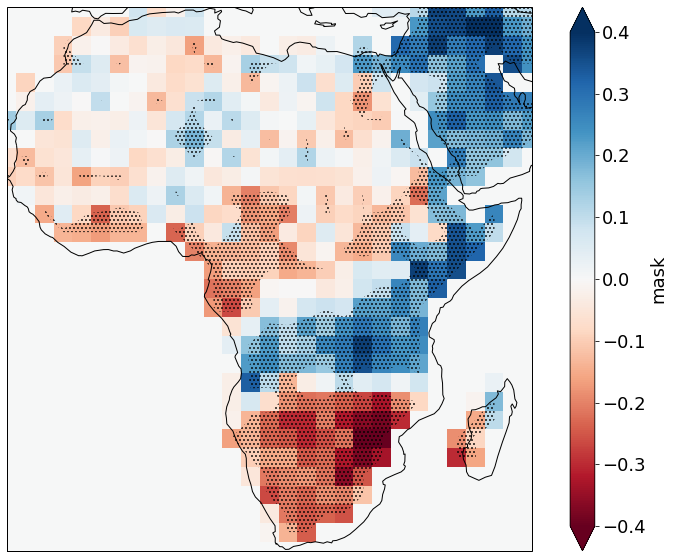

In [ ]:
# Figure 3
map_proj = ccrs.PlateCarree(central_longitude=10)

fig = plt.figure(figsize=(30,10) )

# plot precipitation
ax1 = plt.subplot(1, 2, 1, projection=map_proj)
colormap = plt.cm.RdBu
output.plot(ax=ax1, transform=ccrs.PlateCarree(), 
                             subplot_kws={'projection': map_proj},
                             cmap=colormap,
                            vmin=-0.4, vmax=0.4)

# code for adding stippling to significantly correlating gridcells at alpha=0.05
# Uncomment code below:
# sign.plot.contourf(ax=ax1, levels=[0, 0.05, 1],
#            transform=ccrs.PlateCarree(), hatches=['...', ''],
#            colors='none', add_colorbar=False,
#            subplot_kws={'projection': map_proj})

# ax1.coastlines()


**Question 10**: Interpret the spatial map with correlation coefficients.

## 3: Seasonal dependence of ENSO impact. 

Plot the SPI for each season during El Nino years.

The official definition is that a 3 month running mean of the ENSO 3.4 timeseries should be above (or below) 0.5 degrees Celcius. Hence, We use the raw daily ENSO_34 values and calculate a 3 month rolling mean and then select the dates which were above .5 degrees.

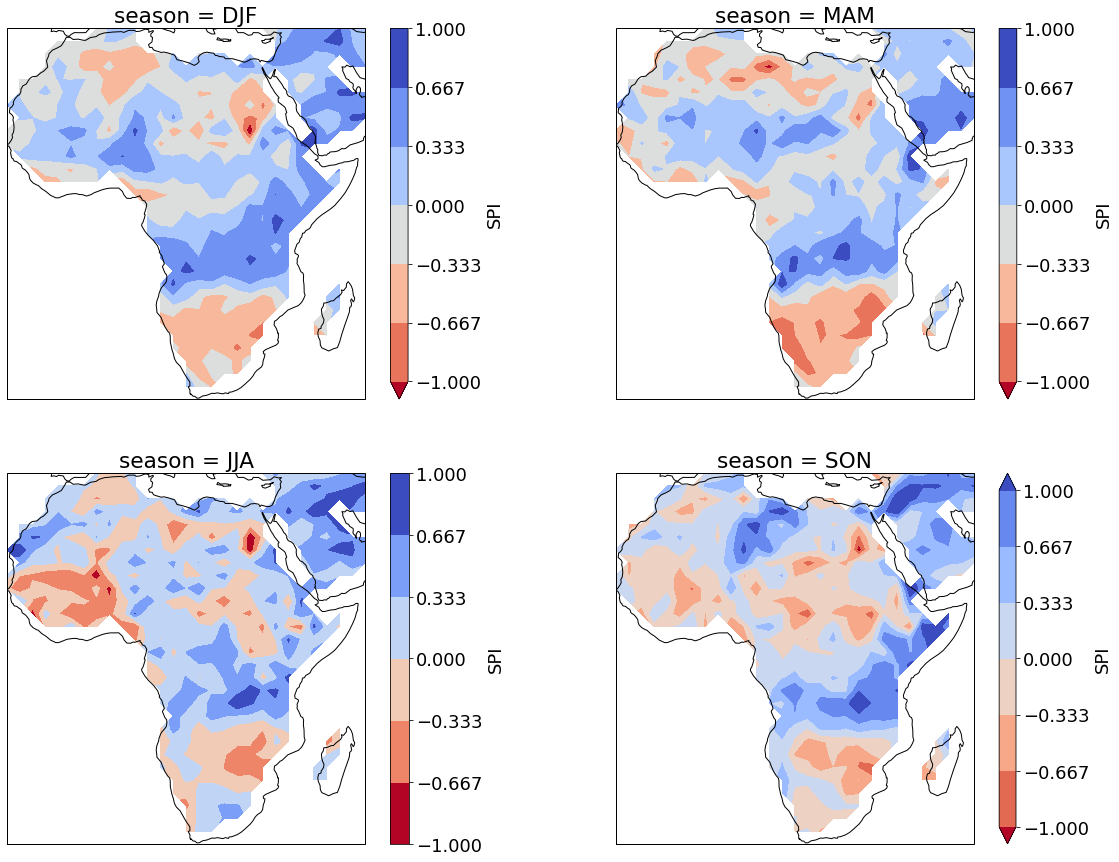

In [ ]:
# Figure 4
ENSO_rm3 = Enso_34_raw.rolling(time=91, center=False, min_periods=1).mean()

mask_ENSO = ENSO_rm3 > 1
ENSO_dates = pd.to_datetime(mask_ENSO[mask_ENSO].time.values)
# match to SPI dates
ENSO_SPI = pd.to_datetime([d for d in SPI_xr.time.values if d in ENSO_dates])


SPI_seasons = SPI_xr.sel(time=ENSO_SPI).groupby('time.season').mean('time')
SPI_seasons.name = 'SPI'
SPI_seasons = SPI_seasons.where(land_sea_mask)

map_proj = ccrs.PlateCarree(central_longitude=10)
colormap = plt.cm.coolwarm_r
plt.figure(figsize=(20,15))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    ax = plt.subplot(2, 2, i+1, projection=map_proj)
    SPI_seasons.sel(season=season).plot.contourf(ax=ax,
                                                 transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': map_proj},
                                                cmap=colormap,
                                                vmin=-1, vmax=1)
    ax.coastlines()

**Question 11**: Where do you observe the strongest seasonal dependence? (insert Figure 4)